/tmp/ipykernel_86339/1038114371.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)


    school_code                     school_name  enrollment  \
0         s3470          ABBEY SECONDARY SCHOOL          11   
1         s0784        AIRWING SECONDARY SCHOOL          97   
2         s3914       ALFAGEMS SECONDARY SCHOOL         299   
3         s3532         ACACIA SECONDARY SCHOOL          37   
4         s0182              AL-FAROUQ SEMINARY          13   
..          ...                             ...         ...   
183       s5000  WAMA-NAKAYAMA SECONDARY SCHOOL          61   
184       s4087           WIZA SECONDARY SCHOOL          17   
185       s1474     WHITE LAKE SECONDARY SCHOOL          23   
186       s2335       YOHANNES SECONDARY SCHOOL          28   
187       s1251           ZIBA SECONDARY SCHOOL         198   

    student_teacher_ratio location     gpa  student_teacher_ratio_numeric  
0                   12:01    Rural  2.8788                           12.0  
1                   16:01    Urban  2.8927                           16.0  
2              

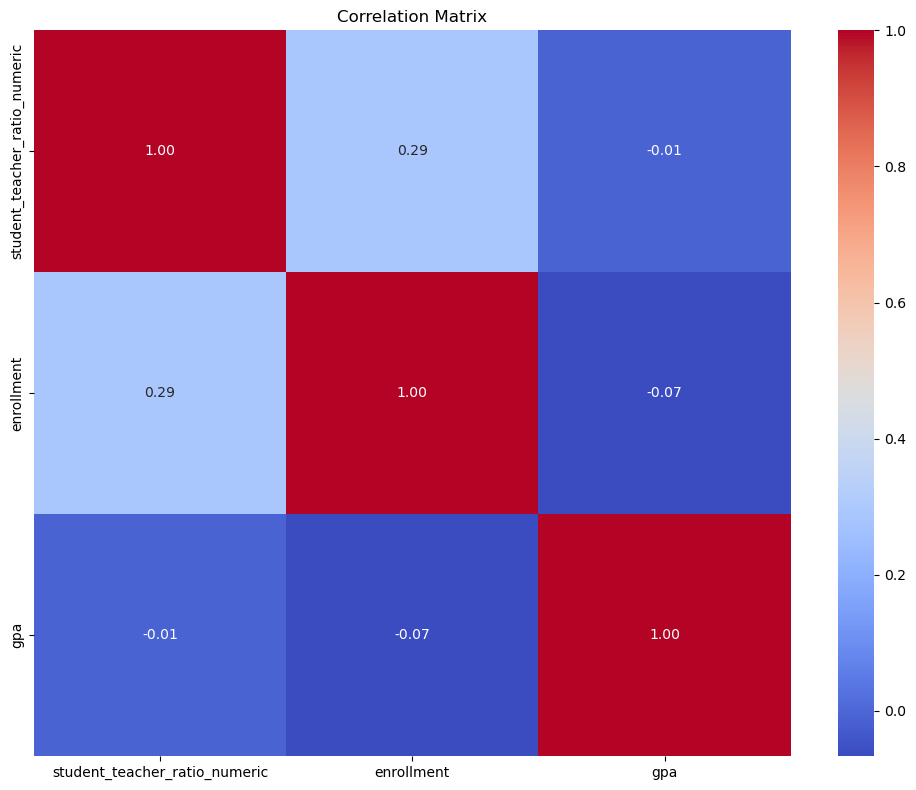

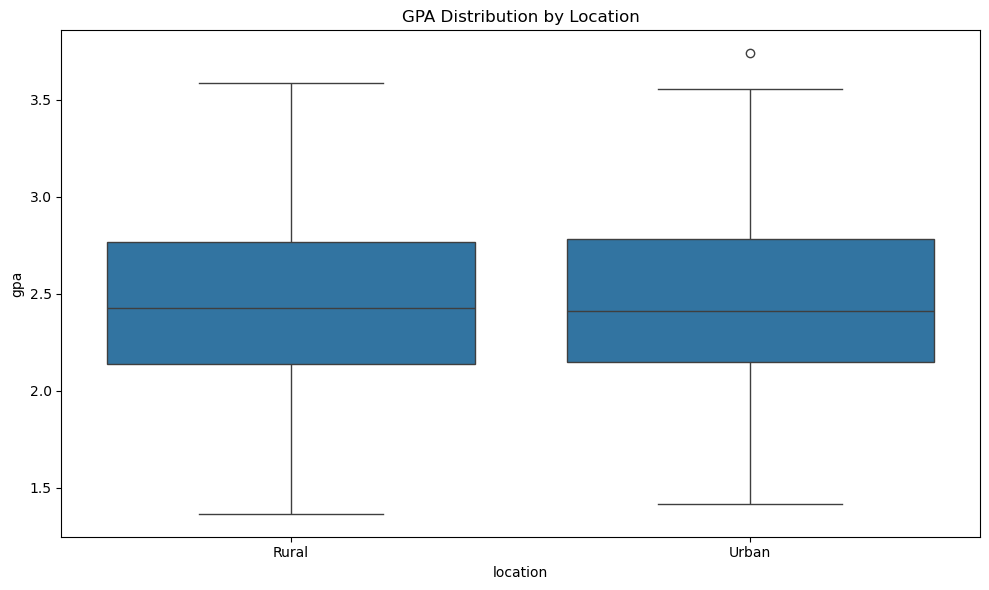

Linear Regression Results:
Mean Squared Error: 0.2468
Root Mean Squared Error: 0.4968
R² Score: -0.0909



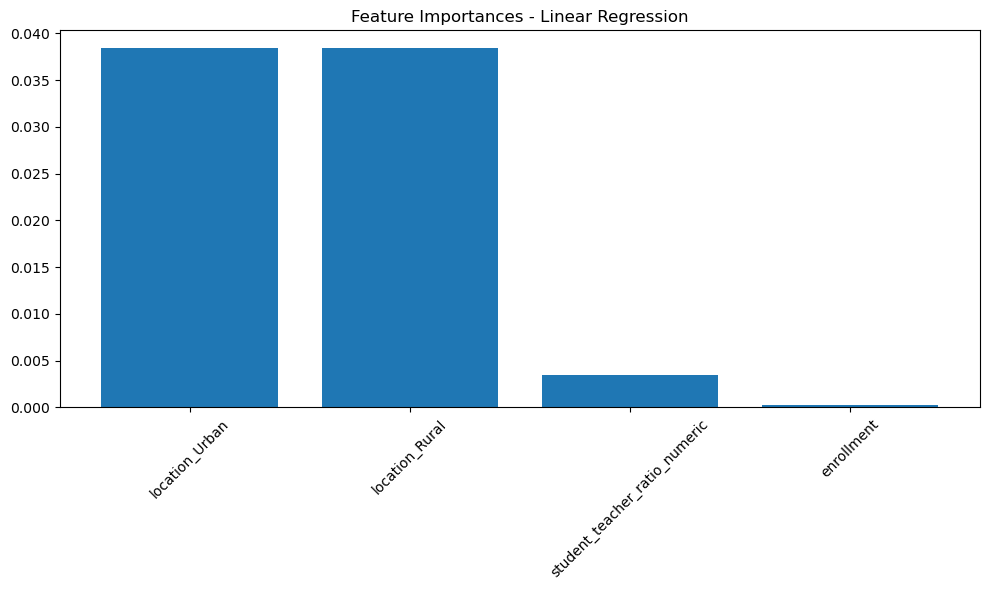

Best Random Forest Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Random Forest Results:
Mean Squared Error: 0.2707
Root Mean Squared Error: 0.5203
R² Score: -0.1964



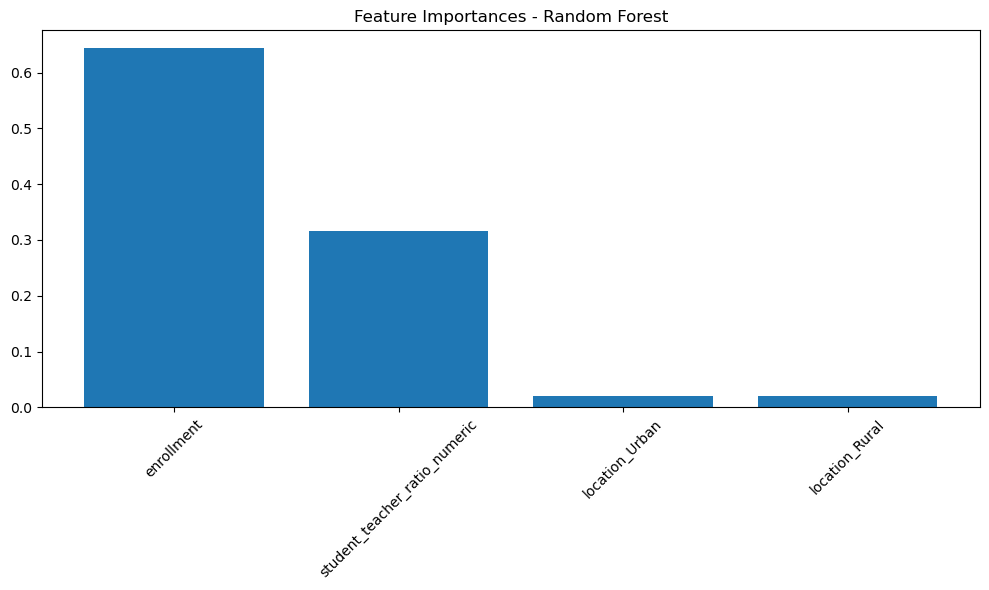

Best XGBoost Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
XGBoost Results:
Mean Squared Error: 0.2377
Root Mean Squared Error: 0.4876
R² Score: -0.0508



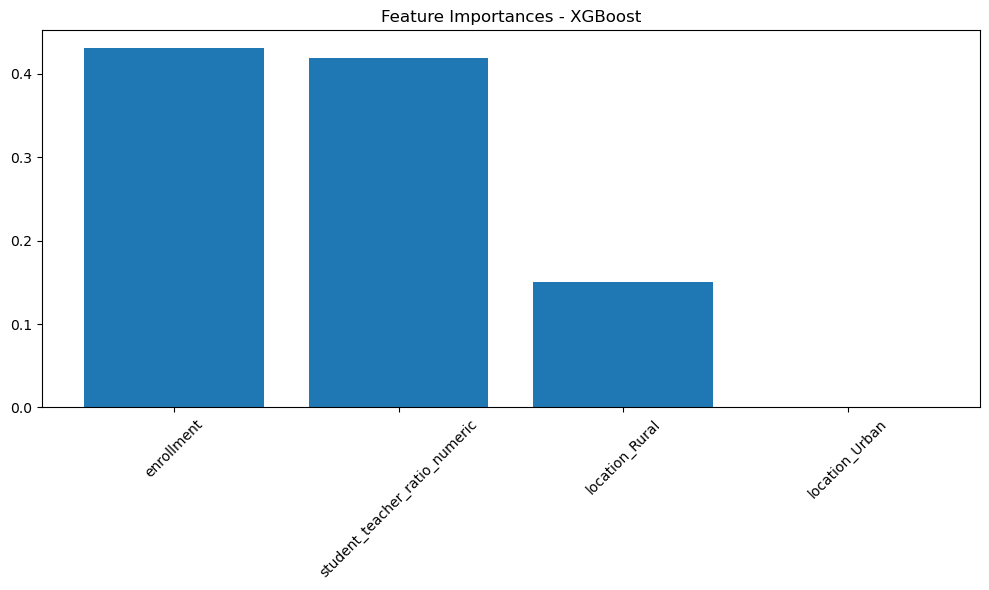

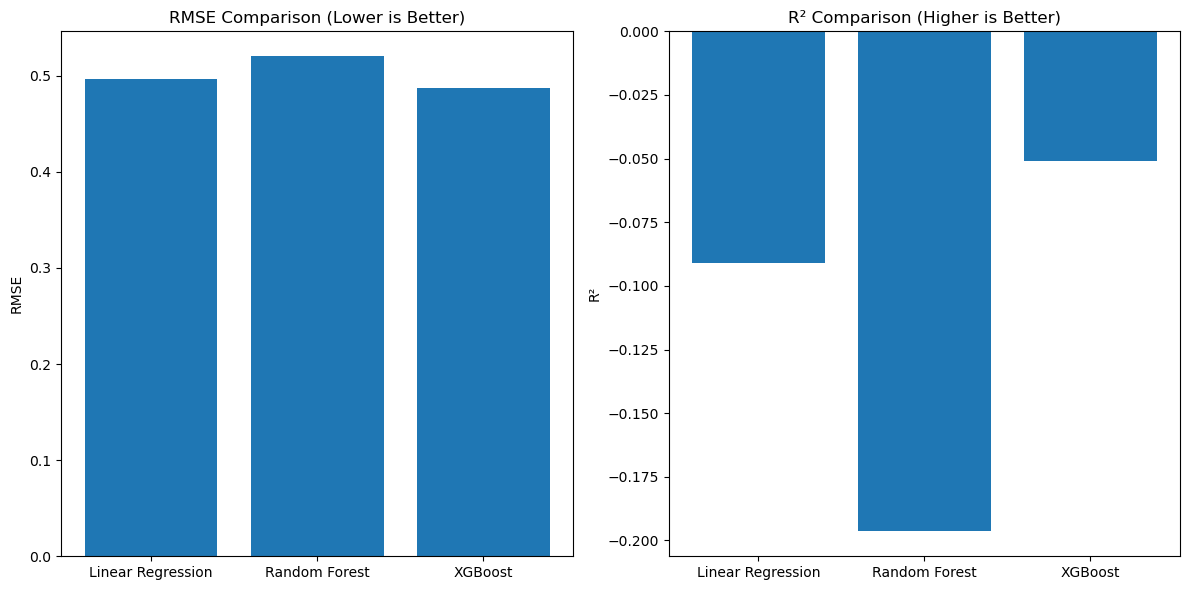


Best performing model: XGBoost

Example predictions:
School with high enrollment (400), high student-teacher ratio (30:1), Urban location:
Predicted GPA: 2.3866

School with low enrollment (20), low student-teacher ratio (10:1), Rural location:
Predicted GPA: 2.6668


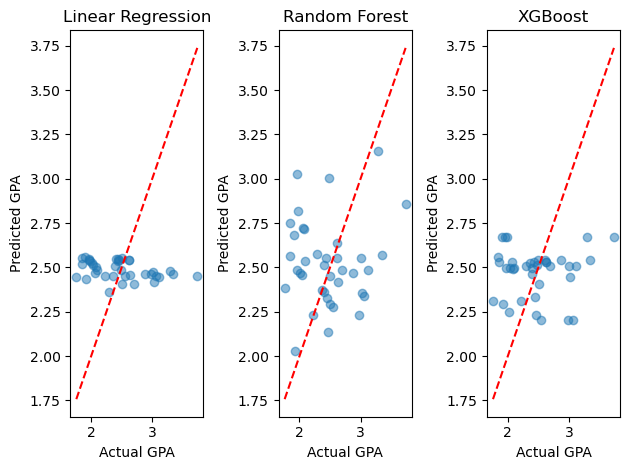

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
def load_and_preprocess_data(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Fix column name if needed (enlorment → enrollment)
    if 'enlorment' in df.columns:
        df = df.rename(columns={'enlorment': 'enrollment'})
    
    # Convert student_teacher_ratio to numeric
    df['student_teacher_ratio_numeric'] = df['student_teacher_ratio'].apply(
        lambda x: float(x.split(':')[0]) if isinstance(x, str) and ':' in x else np.nan
    )
    
    # Handle missing location values (12 nulls found in analysis)
    df['location'].fillna('Unknown', inplace=True)
    
    # Select features and target
    X = df[['student_teacher_ratio_numeric', 'enrollment', 'location']]
    y = df['gpa']
    print(df)
    return X, y, df

# Create a function to evaluate and compare models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print()
    
    return {'mse': mse, 'rmse': rmse, 'r2': r2, 'predictions': y_pred}

# Function to visualize feature importance
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif model_name == 'Linear Regression':
        importances = np.abs(model.coef_)
    else:
        print(f"Cannot extract feature importances from {model_name}")
        return
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances - {model_name}')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show() # plt.savefig(f'{model_name.replace(" ", "_").lower()}_feature_importance.png')
    plt.close()

# Main function
def main():
    # Load and preprocess data
    X, y, df = load_and_preprocess_data('school_data.csv')
    
    # Exploratory Data Analysis
    print("Data Overview:")
    print(f"Number of samples: {len(df)}")
    print(f"Feature statistics:\n{X.describe()}")
    print(f"Target (GPA) statistics:\n{y.describe()}")
    
    # Correlation analysis
    numeric_df = df[['student_teacher_ratio_numeric', 'enrollment', 'gpa']].copy()
    correlation = numeric_df.corr()
    print("\nCorrelation Matrix:")
    print(correlation)
    
    # Visualize correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    
    # GPA by location
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='location', y='gpa', data=df)
    plt.title('GPA Distribution by Location')
    plt.tight_layout()
    plt.show() # plt.savefig('gpa_by_location.png')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define preprocessing for numeric and categorical features
    numeric_features = ['student_teacher_ratio_numeric', 'enrollment']
    categorical_features = ['location']
    
    numeric_transformer = SimpleImputer(strategy='median')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # 1. Linear Regression Model
    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    lr_pipeline.fit(X_train, y_train)
    lr_results = evaluate_model(lr_pipeline, X_test, y_test, "Linear Regression")
    
    # Extract and visualize LR feature importance
    # Get feature names after one-hot encoding
    feature_names = (
        numeric_features + 
        list(lr_pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(categorical_features))
    )
    
    # For linear regression, coefficients represent feature importance
    lr_model = lr_pipeline.named_steps['regressor']
    plot_feature_importance(lr_model, feature_names, "Linear Regression")
    
    # 2. Random Forest Model
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    # Parameter grid for Random Forest
    rf_param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5]
    }
    
    rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
    rf_grid.fit(X_train, y_train)
    
    print("Best Random Forest Parameters:", rf_grid.best_params_)
    rf_results = evaluate_model(rf_grid.best_estimator_, X_test, y_test, "Random Forest")
    
    # Extract and visualize RF feature importance
    rf_model = rf_grid.best_estimator_.named_steps['regressor']
    plot_feature_importance(rf_model, feature_names, "Random Forest")
    
    # 3. XGBoost Model
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42))
    ])
    
    # Parameter grid for XGBoost
    xgb_param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 6]
    }
    
    xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='neg_mean_squared_error')
    xgb_grid.fit(X_train, y_train)
    
    print("Best XGBoost Parameters:", xgb_grid.best_params_)
    xgb_results = evaluate_model(xgb_grid.best_estimator_, X_test, y_test, "XGBoost")
    
    # Extract and visualize XGB feature importance
    xgb_model = xgb_grid.best_estimator_.named_steps['regressor']
    plot_feature_importance(xgb_model, feature_names, "XGBoost")
    
    # Compare models
    models = ["Linear Regression", "Random Forest", "XGBoost"]
    results = [lr_results, rf_results, xgb_results]
    
    plt.figure(figsize=(12, 6))
    
    # RMSE comparison
    plt.subplot(1, 2, 1)
    plt.bar(models, [r['rmse'] for r in results])
    plt.title('RMSE Comparison (Lower is Better)')
    plt.ylabel('RMSE')
    
    # R² comparison
    plt.subplot(1, 2, 2)
    plt.bar(models, [r['r2'] for r in results])
    plt.title('R² Comparison (Higher is Better)')
    plt.ylabel('R²')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    
    # Actual vs Predicted plots
    plt.show() # plt.figure(figsize=(15, 5))
    
    for i, (model_name, result) in enumerate(zip(models, results)):
        plt.subplot(1, 3, i+1)
        plt.scatter(y_test, result['predictions'], alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual GPA')
        plt.ylabel('Predicted GPA')
        plt.title(f'{model_name}')
    
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    
    # Save the best model
    best_model_idx = np.argmax([r['r2'] for r in results])
    best_model_name = models[best_model_idx]
    print(f"\nBest performing model: {best_model_name}")
    
    if best_model_idx == 0:
        best_model = lr_pipeline
    elif best_model_idx == 1:
        best_model = rf_grid.best_estimator_
    else:
        best_model = xgb_grid.best_estimator_
    
    # Example predictions
    print("\nExample predictions:")
    print("School with high enrollment (400), high student-teacher ratio (30:1), Urban location:")
    example_high = pd.DataFrame({
        'student_teacher_ratio_numeric': [30.0],
        'enrollment': [400],
        'location': ['Urban']
    })
    print(f"Predicted GPA: {best_model.predict(example_high)[0]:.4f}")
    
    print("\nSchool with low enrollment (20), low student-teacher ratio (10:1), Rural location:")
    example_low = pd.DataFrame({
        'student_teacher_ratio_numeric': [10.0],
        'enrollment': [20],
        'location': ['Rural']
    })
    print(f"Predicted GPA: {best_model.predict(example_low)[0]:.4f}")

if __name__ == "__main__":
    main()

/tmp/ipykernel_86339/1038114371.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)


    school_code                     school_name  enrollment  \
0         s3470          ABBEY SECONDARY SCHOOL          11   
1         s0784        AIRWING SECONDARY SCHOOL          97   
2         s3914       ALFAGEMS SECONDARY SCHOOL         299   
3         s3532         ACACIA SECONDARY SCHOOL          37   
4         s0182              AL-FAROUQ SEMINARY          13   
..          ...                             ...         ...   
183       s5000  WAMA-NAKAYAMA SECONDARY SCHOOL          61   
184       s4087           WIZA SECONDARY SCHOOL          17   
185       s1474     WHITE LAKE SECONDARY SCHOOL          23   
186       s2335       YOHANNES SECONDARY SCHOOL          28   
187       s1251           ZIBA SECONDARY SCHOOL         198   

    student_teacher_ratio location     gpa  student_teacher_ratio_numeric  
0                   12:01    Rural  2.8788                           12.0  
1                   16:01    Urban  2.8927                           16.0  
2              

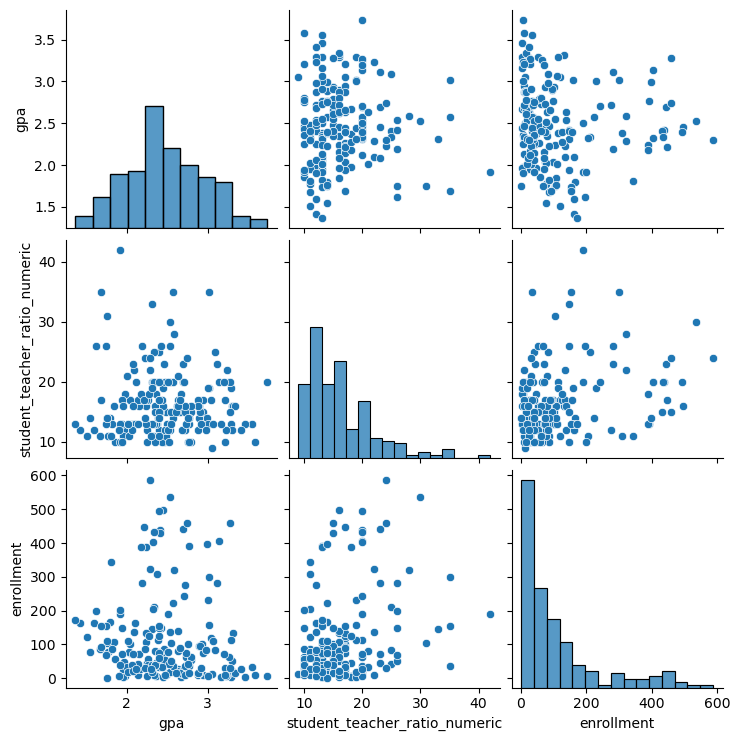

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

X, y, df = load_and_preprocess_data('school_data.csv')
sns.pairplot(df, vars=['gpa', 'student_teacher_ratio_numeric', 'enrollment'])
#plt.show()
plt.savefig('pairplot.png')